## Predicting arrival delays of Airlines

1. We use the US Dept. of Transportation on-time arrival data for non-stop domestic flights by major air carriers to predict.
2. Perform some initial exploratory analysis to look at the probability of delay based on various predictors.
3. We build a machine learning model that is trained to a subset of the full dataset.
4. We finally use a test dataset to determine the accuracy and roc_auc score of the model.

In [91]:
%matplotlib inline

# importing some important libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import time
from sklearn import feature_selection, linear_model
from sklearn import grid_search
import statsmodels.formula.api as smf
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# set some defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [144]:
# The file containing flight records was downloaded from 
# http://transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time

trip_data_file=pd.read_csv('../Airline_Arrival_files/308304637_T_ONTIME.csv')

In [69]:
trip_data_file.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,FIRST_DEP_TIME,Unnamed: 34
0,1,2016-01-04,DL,19790,DL,1479,13487,1348702,31650,MSP,...,-2.0,0.0,0.0,220.0,220.0,174.0,1.0,1487.0,NaN,NaN
1,1,2016-01-04,DL,19790,DL,1479,11697,1169704,32467,FLL,...,-11.0,0.0,0.0,231.0,217.0,201.0,1.0,1487.0,NaN,NaN
2,1,2016-01-04,DL,19790,DL,1480,10529,1052904,30529,BDL,...,5.0,5.0,0.0,118.0,124.0,95.0,1.0,549.0,NaN,NaN
3,1,2016-01-04,DL,19790,DL,1481,12992,1299204,32600,LIT,...,-13.0,0.0,0.0,89.0,78.0,61.0,1.0,453.0,NaN,NaN
4,1,2016-01-04,DL,19790,DL,1482,14492,1449202,34492,RDU,...,1.0,1.0,0.0,98.0,81.0,58.0,1.0,356.0,NaN,NaN


In [70]:
trip_data_file.columns

Index([u'DAY_OF_WEEK', u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID',
       u'CARRIER', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN_AIRPORT_SEQ_ID',
       u'ORIGIN_CITY_MARKET_ID', u'ORIGIN', u'ORIGIN_CITY_NAME',
       u'DEST_AIRPORT_ID', u'DEST_AIRPORT_SEQ_ID', u'DEST_CITY_MARKET_ID',
       u'DEST', u'DEST_CITY_NAME', u'CRS_DEP_TIME', u'DEP_TIME', u'DEP_DELAY',
       u'DEP_DELAY_NEW', u'DEP_DEL15', u'WHEELS_ON', u'TAXI_IN',
       u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY', u'ARR_DELAY_NEW',
       u'ARR_DEL15', u'CRS_ELAPSED_TIME', u'ACTUAL_ELAPSED_TIME', u'AIR_TIME',
       u'FLIGHTS', u'DISTANCE', u'FIRST_DEP_TIME', u'Unnamed: 34'],
      dtype='object')

In [71]:
# The last column called 'Unnamed: 34' contains no useful information and is deleted

del trip_data_file['Unnamed: 34']

In [5]:
trip_data_file.describe()

C:\Users\Anirban\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,DAY_OF_WEEK,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,...,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,FIRST_DEP_TIME
count,445827.000000,445827.000000,445827.000000,445827.000000,4.458270e+05,445827.000000,445827.000000,4.458270e+05,445827.000000,445827.000000,...,433920.000000,433298.000000,433298.000000,433298.000000,445827.000000,433298.000000,433298.000000,445827.0,445827.000000,2552.000000
mean,4.113815,19903.085069,2078.856456,12682.120789,1.268215e+06,31723.938281,12681.700924,1.268173e+06,31723.664890,1330.384387,...,1488.101445,1.533654,10.556042,0.163587,146.499142,140.135200,116.395818,1.0,844.233880,1236.022335
std,2.005007,382.853084,1757.269780,1529.485604,1.529483e+05,1280.460591,1529.329960,1.529327e+05,1280.213952,482.809711,...,518.681533,39.096842,35.235580,0.369901,76.606607,74.753951,72.981191,0.0,610.349957,513.040425
min,1.000000,19393.000000,1.000000,10135.000000,1.013503e+06,30070.000000,10135.000000,1.013503e+06,30070.000000,1.000000,...,1.000000,-79.000000,0.000000,0.000000,21.000000,15.000000,8.000000,1.0,31.000000,6.000000
25%,2.000000,19790.000000,702.000000,11292.000000,1.129202e+06,30615.000000,11292.000000,1.129202e+06,30615.000000,920.000000,...,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,1.0,391.000000,NaN
50%,4.000000,19805.000000,1594.000000,12889.000000,1.288903e+06,31453.000000,12889.000000,1.288903e+06,31453.000000,1325.000000,...,NaN,NaN,NaN,NaN,128.000000,NaN,NaN,1.0,679.000000,NaN
75%,6.000000,20304.000000,2763.000000,14027.000000,1.402702e+06,32467.000000,14027.000000,1.402702e+06,32467.000000,1730.000000,...,NaN,NaN,NaN,NaN,180.000000,NaN,NaN,1.0,1086.000000,NaN
max,7.000000,21171.000000,7438.000000,16218.000000,1.621801e+06,35991.000000,16218.000000,1.621801e+06,35991.000000,2359.000000,...,2400.000000,1659.000000,1659.000000,1.000000,705.000000,721.000000,698.000000,1.0,4983.000000,2354.000000


In [106]:
# Following are the number of flights that have an arrival delay

flights_delayed = trip_data_file[trip_data_file['ARR_DEL15'] == 1].shape[0]
print flights_delayed

142281


In [100]:
# Following are the number of flights that arrive on time

flights_on_time = trip_data_file[trip_data_file['ARR_DEL15'] == 0].shape[0]
print flights_on_time

362416


In [104]:
ratio_of_timely_arrivals = float(flights_on_time)/(float(flights_delayed)+float(flights_on_time))

print ratio_of_timely_arrivals

0.836412815199


### Removing Null Values

We notice that some columns have NaN values. For instance, ARR_TIME, ARR_DELAY, DEP_TIME, DEP_DELAY all have null NaN values. Before proceeding with our analyses, I choose to delete these rows.

In [107]:
trip_data_file[(trip_data_file['ARR_DEL15']>=0)].describe()

,DAY_OF_WEEK,AIRLINE_ID,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,...,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,FIRST_DEP_TIME
count,433298.000000,433298.000000,433298.000000,433298.000000,4.332980e+05,433298.000000,433298.000000,4.332980e+05,433298.000000,433298.000000,...,433298.000000,433298.000000,433298.000000,433298.000000,433298.000000,433298.000000,433298.000000,433298.0,433298.000000,2409.000000
mean,4.088341,19902.293989,2077.255651,12687.277326,1.268731e+06,31722.659435,12686.866002,1.268689e+06,31722.558110,1330.294109,...,1488.060358,1.533654,10.556042,0.163587,146.357544,140.135200,116.395818,1.0,843.752214,1231.625156
std,2.000964,382.617040,1756.814796,1531.194280,1.531191e+05,1282.119028,1531.227798,1.531225e+05,1282.067425,482.799805,...,518.628205,39.096842,35.235580,0.369901,76.479894,74.753951,72.981191,0.0,609.423956,510.120251
min,1.000000,19393.000000,1.000000,10135.000000,1.013503e+06,30070.000000,10135.000000,1.013503e+06,30070.000000,1.000000,...,1.000000,-79.000000,0.000000,0.000000,21.000000,15.000000,8.000000,1.0,31.000000,6.000000
25%,2.000000,19790.000000,701.000000,11292.000000,1.129202e+06,30599.000000,11292.000000,1.129202e+06,30599.000000,920.000000,...,1108.000000,-15.000000,0.000000,0.000000,90.000000,85.000000,62.000000,1.0,391.000000,NaN
50%,4.000000,19805.000000,1591.000000,12889.000000,1.288903e+06,31453.000000,12889.000000,1.288903e+06,31453.000000,1325.000000,...,1522.000000,-7.000000,0.000000,0.000000,128.000000,122.000000,98.000000,1.0,679.000000,NaN
75%,6.000000,20304.000000,2762.000000,14057.000000,1.405702e+06,32467.000000,14027.000000,1.402702e+06,32467.000000,1730.000000,...,1919.000000,5.000000,5.000000,0.000000,180.000000,173.000000,148.000000,1.0,1089.000000,NaN
max,7.000000,21171.000000,7438.000000,16218.000000,1.621801e+06,35991.000000,16218.000000,1.621801e+06,35991.000000,2359.000000,...,2400.000000,1659.000000,1659.000000,1.000000,705.000000,721.000000,698.000000,1.0,4983.000000,2354.000000


In [108]:
# Below are all the records that contain NaN values for ARR_TIME, ARR_DELAY, DEP_TIME, DEP_DELAY

trip_data_file[~(trip_data_file['ARR_DEL15']>=0)]

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,FIRST_DEP_TIME
284,1,2016-01-04,DL,19790,DL,1724,10529,1052904,30529,BDL,...,2254.0,NaN,NaN,NaN,170.0,NaN,NaN,1.0,859.0,NaN
654,1,2016-01-04,DL,19790,DL,2755,14771,1477102,32457,SFO,...,NaN,NaN,NaN,NaN,95.0,NaN,NaN,1.0,337.0,812.0
1077,1,2016-01-04,DL,19790,DL,898,14057,1405702,34057,PDX,...,1258.0,NaN,NaN,NaN,192.0,NaN,NaN,1.0,1426.0,NaN
3753,1,2016-01-18,DL,19790,DL,794,15304,1530402,33195,TPA,...,51.0,NaN,NaN,NaN,169.0,NaN,NaN,1.0,1010.0,NaN
4165,1,2016-01-18,DL,19790,DL,1507,10397,1039705,30397,ATL,...,1909.0,NaN,NaN,NaN,262.0,NaN,NaN,1.0,1590.0,NaN
4546,1,2016-01-18,DL,19790,DL,1076,14747,1474703,30559,SEA,...,737.0,NaN,NaN,NaN,162.0,NaN,NaN,1.0,909.0,NaN
6062,1,2016-01-25,DL,19790,DL,1139,11278,1127803,30852,DCA,...,NaN,NaN,NaN,NaN,124.0,NaN,NaN,1.0,547.0,NaN
6073,1,2016-01-25,DL,19790,DL,1150,12953,1295302,31703,LGA,...,NaN,NaN,NaN,NaN,259.0,NaN,NaN,1.0,1389.0,NaN
6124,1,2016-01-25,DL,19790,DL,1187,13487,1348702,31650,MSP,...,2239.0,NaN,NaN,NaN,229.0,NaN,NaN,1.0,1399.0,NaN
6187,1,2016-01-25,DL,19790,DL,1239,11278,1127803,30852,DCA,...,NaN,NaN,NaN,NaN,130.0,NaN,NaN,1.0,547.0,NaN


In [109]:
trip_data_valid_records = trip_data_file[(trip_data_file['ARR_DEL15']>=0)]
trip_data_valid_records.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,FIRST_DEP_TIME
0,1,2016-01-04,DL,19790,DL,1479,13487,1348702,31650,MSP,...,1208.0,-2.0,0.0,0.0,220.0,220.0,174.0,1.0,1487.0,NaN
1,1,2016-01-04,DL,19790,DL,1479,11697,1169704,32467,FLL,...,1600.0,-11.0,0.0,0.0,231.0,217.0,201.0,1.0,1487.0,NaN
2,1,2016-01-04,DL,19790,DL,1480,10529,1052904,30529,BDL,...,803.0,5.0,5.0,0.0,118.0,124.0,95.0,1.0,549.0,NaN
3,1,2016-01-04,DL,19790,DL,1481,12992,1299204,32600,LIT,...,816.0,-13.0,0.0,0.0,89.0,78.0,61.0,1.0,453.0,NaN
4,1,2016-01-04,DL,19790,DL,1482,14492,1449202,34492,RDU,...,904.0,1.0,1.0,0.0,98.0,81.0,58.0,1.0,356.0,NaN


In [110]:
print trip_data_valid_records['UNIQUE_CARRIER'].unique()
print trip_data_valid_records['UNIQUE_CARRIER'].unique().size

['DL' 'EV' 'F9' 'HA' 'NK' 'OO' 'UA' 'VX' 'WN' 'AA' 'AS' 'B6']
12


### Analyzing performance of different airlines

Having got rid of null values, we proceed to analyze how different airlines perform. This is part of our exploratory data analysis. I first create a dataframe that contains information on how many flights had delayed arrivals and how many were on time for each airline.

In [122]:
airline_delay = pd.DataFrame(columns=['Airline','Delayed_flts','On_time_flts','Delay_pcntg'])

for carrier in trip_data_valid_records['UNIQUE_CARRIER'].unique():
    num_of_del_arr = trip_data_valid_records[(trip_data_valid_records['UNIQUE_CARRIER'] == carrier) & 
                                                     (trip_data_valid_records['ARR_DEL15'] == 1)].shape[0]
    num_on_time_arr = trip_data_valid_records[(trip_data_valid_records['UNIQUE_CARRIER'] == carrier) & 
                                                     (trip_data_valid_records['ARR_DEL15'] == 0)].shape[0]
    percentage_delay = float(num_of_del_arr)/float(num_on_time_arr+num_of_del_arr)
    
    airline_delay = airline_delay.append({'Airline':carrier, 'Delayed_flts':num_of_del_arr, 
                                          'On_time_flts':num_on_time_arr, 'Delay_pcntg':percentage_delay},ignore_index=True)

airline_delay

,Airline,Delayed_flts,On_time_flts,Delay_pcntg
0,DL,9234.0,59415.0,0.134510
1,EV,6375.0,34073.0,0.157610
2,F9,978.0,6040.0,0.139356
3,HA,510.0,5760.0,0.081340
4,NK,3210.0,7519.0,0.299189
5,OO,9499.0,36942.0,0.204539
6,UA,5571.0,32798.0,0.145195
7,VX,1205.0,4013.0,0.230931
8,WN,14103.0,87232.0,0.139172
9,AA,12444.0,60292.0,0.171084


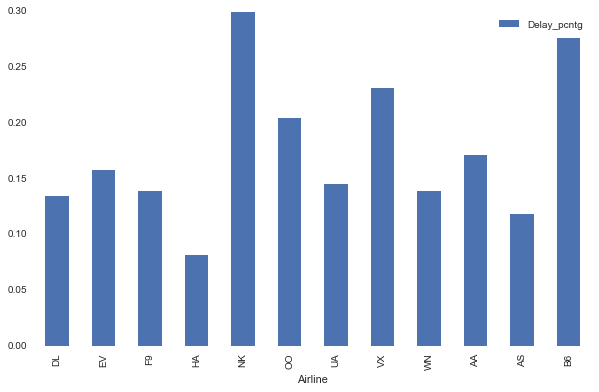

In [127]:
airline_delay.plot(x= 'Airline', y= 'Delay_pcntg', kind='bar')

Jet Blue and Spirit (B6 and NK respectively) have higher rates of delayed flights than other airlines.

Next, we attempt to build a linear regression model that can estimate the arrival delay time. We use the ordinary least squares or ols library from statsmodels. Initially, we use the carrier as the only predictor. Subsequently, we add more and more predictors to look at whether the model can be improved. 

### Linear Regression models for arrive delay estimation

In the following sections, we build several linear regression models using different predictors. The <b>R<sup>2</sup></b> value is used as a metric to determine the accuracy of the model.

In [40]:
lm = smf.ols(formula='ARR_DELAY ~ UNIQUE_CARRIER', data=trip_data_valid_records).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DELAY   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     420.5
Date:                Sun, 27 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:33:24   Log-Likelihood:            -2.2010e+06
No. Observations:              433298   AIC:                         4.402e+06
Df Residuals:                  433286   BIC:                         4.402e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.9343      0.144     13.414      0.000         1.652     2.217
UNIQUE_CARRIER[T.AS]    -5.8571      0.359    -16.326      0.000        -6.560    -5.154
UNIQUE_CARRIER[T.B6]     8.1935      0.299     27.414      0.000         7.608     8.779
UNIQUE_CARRIER[T.DL]    -2.7730      0.207    -13.400      0.000        -3.179    -2.367
UNIQUE_CARRIER[T.EV]    -0.3062      0.241     -1.269      0.204        -0.779     0.167
UNIQUE_CARRIER[T.F9]    -3.7945      0.486     -7.806      0.000        -4.747    -2.842
UNIQUE_CARRIER[T.HA]    -3.5633      0.512     -6.961      0.000        -4.567    -2.560
UNIQUE_CARRIER[T.NK]    11.1935      0.402     27.831      0.000        10.405    11.982
UNIQUE_CARRIER[T.OO]     5.5123      0.231     23.863      0.000         5.060     5.965
UNIQUE_CARRIER[T.UA]    -4.8233      0.245    -19.656      0.000        -5.304    -4.342
UNIQUE_CARRIER[T.VX]     5.6815      0.557     10.194      0.000         4.589     6.774
UNIQUE_CARRIER[T.WN]    -2.3809      0.189    -12.598      0.000        -2.751    -2.010
==============================================================================
Omnibus:                   623265.168   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        459430548.568
Skew:                           8.360   Prob(JB):                         0.00
Kurtosis:                     161.644   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### New Variables for Day of the Week

In order to have the day of the week as a predictor we need to create dummy variables. For example, a column DAY_1 will have a value of 1 if the flight departs on Monday, and 0 for all other days of the week. DAY_2 will be 1 if the flight departs on a Tuesday, and so on.

In [129]:
week_day = pd.get_dummies(trip_data_valid_records.DAY_OF_WEEK, prefix = 'DAY')
trip_data_valid_records = trip_data_valid_records.join(week_day)

trip_data_valid_records.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,FLIGHTS,DISTANCE,FIRST_DEP_TIME,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7
0,1,2016-01-04,DL,19790,DL,1479,13487,1348702,31650,MSP,...,1.0,1487.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2016-01-04,DL,19790,DL,1479,11697,1169704,32467,FLL,...,1.0,1487.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2016-01-04,DL,19790,DL,1480,10529,1052904,30529,BDL,...,1.0,549.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2016-01-04,DL,19790,DL,1481,12992,1299204,32600,LIT,...,1.0,453.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2016-01-04,DL,19790,DL,1482,14492,1449202,34492,RDU,...,1.0,356.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
trip_data_valid_records.columns

Index([u'DAY_OF_WEEK', u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID',
       u'CARRIER', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN_AIRPORT_SEQ_ID',
       u'ORIGIN_CITY_MARKET_ID', u'ORIGIN', u'ORIGIN_CITY_NAME',
       u'DEST_AIRPORT_ID', u'DEST_AIRPORT_SEQ_ID', u'DEST_CITY_MARKET_ID',
       u'DEST', u'DEST_CITY_NAME', u'CRS_DEP_TIME', u'DEP_TIME', u'DEP_DELAY',
       u'DEP_DELAY_NEW', u'DEP_DEL15', u'WHEELS_ON', u'TAXI_IN',
       u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY', u'ARR_DELAY_NEW',
       u'ARR_DEL15', u'CRS_ELAPSED_TIME', u'ACTUAL_ELAPSED_TIME', u'AIR_TIME',
       u'FLIGHTS', u'DISTANCE', u'FIRST_DEP_TIME', u'DAY_1', u'DAY_2',
       u'DAY_3', u'DAY_4', u'DAY_5', u'DAY_6', u'DAY_7'],
      dtype='object')

In [15]:
lm = smf.ols(formula='ARR_DELAY ~ UNIQUE_CARRIER + DAY_1 + DAY_2 + DAY_3 + DAY_4 + DAY_5 + DAY_6 + DAY_7', 
             data=trip_data_valid_records).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DELAY   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     109.2
Date:                Sun, 27 Nov 2016   Prob (F-statistic):               0.00
Time:                        14:53:08   Log-Likelihood:            -7.7252e+05
No. Observations:              142281   AIC:                         1.545e+06
Df Residuals:                  142262   BIC:                         1.545e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             1.562e+12   4.73e+12      0.331      0.741      -7.7e+12  1.08e+13
UNIQUE_CARRIER[T.AS]    -6.7662      0.936     -7.228      0.000        -8.601    -4.931
UNIQUE_CARRIER[T.B6]     6.6155      0.649     10.194      0.000         5.344     7.887
UNIQUE_CARRIER[T.DL]     3.1001      0.539      5.747      0.000         2.043     4.157
UNIQUE_CARRIER[T.EV]     4.5033      0.610      7.388      0.000         3.309     5.698
UNIQUE_CARRIER[T.F9]    10.9244      1.353      8.071      0.000         8.272    13.577
UNIQUE_CARRIER[T.HA]   -17.0810      1.322    -12.921      0.000       -19.672   -14.490
UNIQUE_CARRIER[T.NK]     5.2676      0.823      6.403      0.000         3.655     6.880
UNIQUE_CARRIER[T.OO]     8.4992      0.540     15.749      0.000         7.441     9.557
UNIQUE_CARRIER[T.UA]     6.5397      0.658      9.946      0.000         5.251     7.828
UNIQUE_CARRIER[T.VX]     7.0616      1.242      5.686      0.000         4.627     9.496
UNIQUE_CARRIER[T.WN]    -6.9061      0.464    -14.868      0.000        -7.817    -5.996
DAY_1                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
DAY_2                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
DAY_3                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
DAY_4                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
DAY_5                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
DAY_6                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
DAY_7                -1.562e+12   4.73e+12     -0.331      0.741     -1.08e+13   7.7e+12
==============================================================================
Omnibus:                   184595.570   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         60085349.580
Skew:                           7.098   Prob(JB):                         0.00
Kurtosis:                     102.668   Cond. No.                     1.02e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.7e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [16]:
# trip_data_valid_records.iloc[0]

In [17]:
%%time
lm1 = smf.ols(formula='ARR_DELAY ~ UNIQUE_CARRIER + ORIGIN + DAY_1 + DAY_2 + DAY_3 + DAY_4 + DAY_5 + DAY_6 + DAY_7', 
             data=trip_data_valid_records).fit()

Wall time: 13.9 s


In [18]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DELAY   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     11.45
Date:                Sun, 27 Nov 2016   Prob (F-statistic):               0.00
Time:                        14:53:22   Log-Likelihood:            -7.7174e+05
No. Observations:              142281   AIC:                         1.544e+06
Df Residuals:                  141971   BIC:                         1.547e+06
Df Model:                         309                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             6.342e+12    1.1e+13      0.575      0.565     -1.53e+13   2.8e+13
UNIQUE_CARRIER[T.AS]    -6.3311      1.150     -5.507      0.000        -8.584    -4.078
UNIQUE_CARRIER[T.B6]     2.5519      0.762      3.348      0.001         1.058     4.046
UNIQUE_CARRIER[T.DL]     2.1387      0.647      3.308      0.001         0.872     3.406
UNIQUE_CARRIER[T.EV]     1.7925      0.743      2.412      0.016         0.336     3.249
UNIQUE_CARRIER[T.F9]    10.9306      1.405      7.779      0.000         8.176    13.685
UNIQUE_CARRIER[T.HA]   -19.9662      2.051     -9.737      0.000       -23.985   -15.947
UNIQUE_CARRIER[T.NK]     3.4696      0.903      3.844      0.000         1.700     5.239
UNIQUE_CARRIER[T.OO]     7.0043      0.675     10.375      0.000         5.681     8.328
UNIQUE_CARRIER[T.UA]     5.9692      0.732      8.152      0.000         4.534     7.404
UNIQUE_CARRIER[T.VX]     4.1764      1.300      3.212      0.001         1.628     6.725
UNIQUE_CARRIER[T.WN]    -7.3088      0.571    -12.800      0.000        -8.428    -6.190
ORIGIN[T.ABQ]          -15.5310      8.960     -1.733      0.083       -33.093     2.031
ORIGIN[T.ABR]          -23.4551     12.479     -1.880      0.060       -47.914     1.004
ORIGIN[T.ABY]          -14.4574     14.522     -0.996      0.319       -42.920    14.005
ORIGIN[T.ACT]          -17.0166     13.943     -1.220      0.222       -44.345    10.312
ORIGIN[T.ACV]          -19.2925     10.980     -1.757      0.079       -40.813     2.228
ORIGIN[T.ACY]          -19.3967      9.558     -2.029      0.042       -38.130    -0.663
ORIGIN[T.ADK]          -17.3177     26.053     -0.665      0.506       -68.382    33.747
ORIGIN[T.ADQ]          -26.6081     21.269     -1.251      0.211       -68.295    15.078
ORIGIN[T.AEX]          -13.3002     11.133     -1.195      0.232       -35.121     8.520
ORIGIN[T.AGS]            0.1266     11.576      0.011      0.991       -22.561    22.814
ORIGIN[T.ALB]           -9.4199      9.531     -0.988      0.323       -28.101     9.261
ORIGIN[T.AMA]          -15.4566     10.869     -1.422      0.155       -36.760     5.847
ORIGIN[T.ANC]          -26.2214      9.082     -2.887      0.004       -44.022    -8.421
ORIGIN[T.APN]           40.7107     15.002      2.714      0.007        11.308    70.114
ORIGIN[T.ASE]          -16.6331      9.236     -1.801      0.072       -34.736     1.469
ORIGIN[T.ATL]          -19.0324      8.611     -2.210      0.027       -35.910    -2.155
ORIGIN[T.ATW]          -19.0030     10.270     -1.850      0.064       -39.132     1.126
ORIGIN[T.AUS]          -17.8076      8.794     -2.025      0.043       -35.043    -0.572
ORIGIN[T.AVL]            8.3330     11.134      0.748      0.454       -13.490    30.156
ORIGIN[T.AVP]          -18.3280     12.644     -1.450    

In [130]:
%%time
lm2 = smf.ols(formula='ARR_DELAY ~ UNIQUE_CARRIER + ORIGIN + FLIGHTS + DAY_1 + DAY_2 + DAY_3 + DAY_4 + DAY_5 + DAY_6 + DAY_7 + CRS_DEP_TIME', 
             data=trip_data_valid_records).fit()

Wall time: 1min 27s


In [131]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DELAY   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     37.52
Date:                Sun, 27 Nov 2016   Prob (F-statistic):               0.00
Time:                        20:53:37   Log-Likelihood:            -2.1976e+06
No. Observations:              433298   AIC:                         4.396e+06
Df Residuals:                  432986   BIC:                         4.399e+06
Df Model:                         311                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -2.7533      1.380     -1.995      0.046        -5.458    -0.048
UNIQUE_CARRIER[T.AS]    -8.7316      0.442    -19.770      0.000        -9.597    -7.866
UNIQUE_CARRIER[T.B6]     9.1044      0.338     26.958      0.000         8.443     9.766
UNIQUE_CARRIER[T.DL]    -2.7868      0.240    -11.595      0.000        -3.258    -2.316
UNIQUE_CARRIER[T.EV]     0.2558      0.288      0.889      0.374        -0.308     0.820
UNIQUE_CARRIER[T.F9]    -4.4149      0.504     -8.751      0.000        -5.404    -3.426
UNIQUE_CARRIER[T.HA]     7.4975      0.821      9.137      0.000         5.889     9.106
UNIQUE_CARRIER[T.NK]    10.5392      0.423     24.898      0.000         9.710    11.369
UNIQUE_CARRIER[T.OO]     3.1183      0.280     11.156      0.000         2.570     3.666
UNIQUE_CARRIER[T.UA]    -5.2695      0.273    -19.310      0.000        -5.804    -4.735
UNIQUE_CARRIER[T.VX]     1.6941      0.577      2.938      0.003         0.564     2.824
UNIQUE_CARRIER[T.WN]    -2.8619      0.227    -12.590      0.000        -3.307    -2.416
ORIGIN[T.ABQ]            3.3331      3.123      1.067      0.286        -2.788     9.454
ORIGIN[T.ABR]           13.1816      5.725      2.303      0.021         1.962    24.402
ORIGIN[T.ABY]            2.7641      5.246      0.527      0.598        -7.517    13.045
ORIGIN[T.ACT]           -9.6326      4.351     -2.214      0.027       -18.161    -1.104
ORIGIN[T.ACV]           11.0464      4.611      2.396      0.017         2.009    20.084
ORIGIN[T.ACY]            5.1606      3.731      1.383      0.167        -2.151    12.473
ORIGIN[T.ADK]           15.1103     13.206      1.144      0.253       -10.772    40.993
ORIGIN[T.ADQ]           -0.2448      6.861     -0.036      0.972       -13.691    13.202
ORIGIN[T.AEX]           -1.7939      3.987     -0.450      0.653        -9.607     6.020
ORIGIN[T.AGS]            3.2428      4.037      0.803      0.422        -4.670    11.156
ORIGIN[T.ALB]           -4.2725      3.276     -1.304      0.192       -10.693     2.148
ORIGIN[T.AMA]            2.6673      3.859      0.691      0.489        -4.897    10.231
ORIGIN[T.ANC]            4.2053      3.170      1.327      0.185        -2.008    10.418
ORIGIN[T.APN]           28.0308      6.307      4.444      0.000        15.669    40.392
ORIGIN[T.ASE]            7.1416      3.365      2.122      0.034         0.546    13.737
ORIGIN[T.ATL]            0.4640      2.957      0.157      0.875        -5.332     6.260
ORIGIN[T.ATW]            3.0887      3.786      0.816      0.415        -4.331    10.509
ORIGIN[T.AUS]           -1.4827      3.022     -0.491      0.624        -7.405     4.440
ORIGIN[T.AVL]            6.8541      4.048      1.693      0.090        -1.080    14.788
ORIGIN[T.AVP]           -4.7573      4.343     -1.095    

### Linear Regression model: Conclusion

Using predictors such as Airline Carrier, Origin Airport, Day of the week, and departure time of the flight, we are able to improve on the initial model that considered the Airline Carrier alone. Other possible estimators that could have been considered are the weather data at the origin and destination airports, which would require external datasets.

### Classification models: Logistic Regression and Random Forest

Next, we build two classification models with ARR_DEL15 as the output variable.

A new set of dummy variables for the carrier airlines is created.

In [43]:
unique_carrier = pd.get_dummies(trip_data_valid_records.UNIQUE_CARRIER, prefix = 'CARRIER')
trip_data_valid_records = trip_data_valid_records.join(unique_carrier)

trip_data_valid_records.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,CARRIER_B6,CARRIER_DL,CARRIER_EV,CARRIER_F9,CARRIER_HA,CARRIER_NK,CARRIER_OO,CARRIER_UA,CARRIER_VX,CARRIER_WN
0,1,2016-01-04,DL,19790,DL,1479,13487,1348702,31650,MSP,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2016-01-04,DL,19790,DL,1479,11697,1169704,32467,FLL,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2016-01-04,DL,19790,DL,1480,10529,1052904,30529,BDL,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2016-01-04,DL,19790,DL,1481,12992,1299204,32600,LIT,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2016-01-04,DL,19790,DL,1482,14492,1449202,34492,RDU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
# We define an array containing all the features to be used for prediction.

features = [i for i in trip_data_valid_records.columns if (('DAY_' in i) & (i != 'DAY_OF_WEEK')) ]
features+= [i for i in trip_data_valid_records.columns if ('CARRIER_' in i)]
features+= ['CRS_DEP_TIME']

### Plotting probabilities

The <b>Probability</b> of a flight having a delayed arrival is plotted against the <b>departure time, airline carrier, and day of the week</b>

In [134]:
trip_data_valid_records['probability'] = model.predict_proba(trip_data_valid_records[features[0:]]).T[1]

trip_data_valid_records.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,DISTANCE,FIRST_DEP_TIME,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7,probability
0,1,2016-01-04,DL,19790,DL,1479,13487,1348702,31650,MSP,...,1487.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143796
1,1,2016-01-04,DL,19790,DL,1479,11697,1169704,32467,FLL,...,1487.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179908
2,1,2016-01-04,DL,19790,DL,1480,10529,1052904,30529,BDL,...,549.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136700
3,1,2016-01-04,DL,19790,DL,1481,12992,1299204,32600,LIT,...,453.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136700
4,1,2016-01-04,DL,19790,DL,1482,14492,1449202,34492,RDU,...,356.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143518


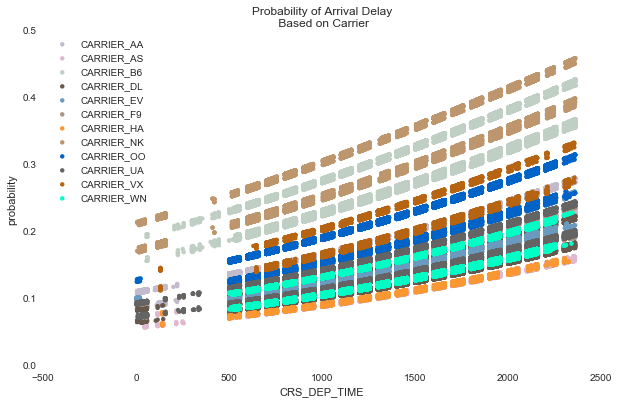

In [73]:
ax = plt.subplot(111)

carriers = [i for i in features if ('CARRIER_' in i)]

colors = ['#c3bacb', '#e0b9d1', '#c0cfc4', '#66584d', '#6b9abf', '#ab9683','#fa9732','#bd966d', '#0063c8',
          '#646464','#b66412','#00ffc5']
for e, c in enumerate(colors):
    trip_data_valid_records[trip_data_valid_records[carriers[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', 
                                                                            kind='scatter', color = c, ax=ax, label=carriers[e])

ax.set(title='Probability of Arrival Delay\n Based on Carrier')
plt.legend(loc=2)

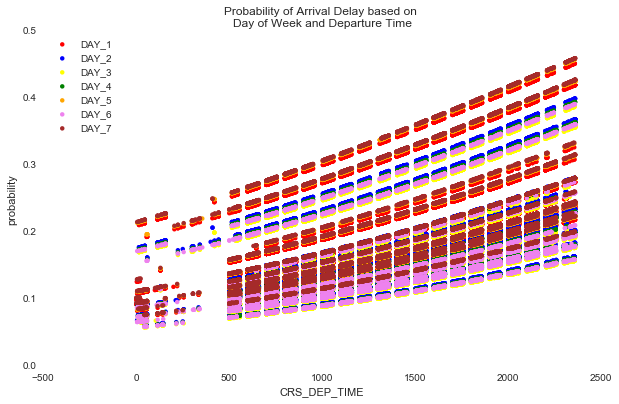

In [72]:
ax = plt.subplot(111)

day_of_week = [i for i in features if ('DAY_' in i)]

colors = ['red', 'blue', 'yellow', 'green', 'orange', 'violet','brown']
for e, c in enumerate(colors):
    trip_data_valid_records[trip_data_valid_records[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', 
                                                                            kind='scatter', color = c, ax=ax, label=day_of_week[e])

ax.set(title='Probability of Arrival Delay based on \nDay of Week and Departure Time')
plt.legend(loc=2)

As we see, probability of delay increases during later part of the day. Also, certain airlines have higher probability of delay. Also, Friday, Sunday, and Monday have more delays relative to other days of the week.

In the following sections, we perform grid search with cross validation in order to determine the best performing models using Logistic Regression and Random Forest.

In [143]:
X = trip_data_valid_records[features[0:]]
y = trip_data_valid_records['ARR_DEL15']

# Grid search with logistic regression
Cs = np.arange(1, 100, 10)
gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid={'C': Cs},
    scoring='roc_auc',
    cv = 5)
    
gs.fit(X, y.ravel())
    
print gs.best_score_ # tells us the best roc_auc_score from all different parameters.
print gs.best_estimator_ # explains which grid_search setup worked best

0.550178264734
LogisticRegression(C=21, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [141]:
%%time

train_data,test_data,train_op,test_op = train_test_split(X,y,test_size=0.2)

logistic = linear_model.LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logistic.fit(train_data, train_op.ravel())

output = logistic.predict(test_data)

print accuracy_score(test_op, output)
print roc_auc_score(test_op, output)

0.835056542811
0.5
Wall time: 1.3 s


In [142]:
%%time

train_data,test_data,train_op,test_op = train_test_split(X,y,test_size=0.2)

forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=2)
forest.fit(train_data, train_op.ravel())

output = forest.predict(test_data)

print accuracy_score(test_op, output)
print roc_auc_score(test_op, output)

0.835991230095
0.500248397603
Wall time: 57.9 s


### Classification models: Conclusion

Both Logistic and Random Forest Classifiers performed at about similar accuracy. However, the accuracy is close to that predicted by pure chance, since this dataset is unbalanced. The low value of the ROC-AUC score indicates that this model is not yet optimum and needs to be improved.